# Gaussian Process implementation with JAX 

In [1]:
import gp
import jax.numpy as jnp
from jax import jacrev, jit, lax, random, tree_map, vmap
import matplotlib.pyplot as plt
from jax import random
from functools import partial
%matplotlib inline
import numpy as np

Prior

In [2]:
key = random.PRNGKey(42)

X = jnp.arange(-5, 5, 0.2).reshape(-1, 1)
mu = jnp.zeros(X.shape)
cov = gp.kernel(X,X)

/tmp/ipykernel_2749/2415798315.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu.ravel(), cov, 3)


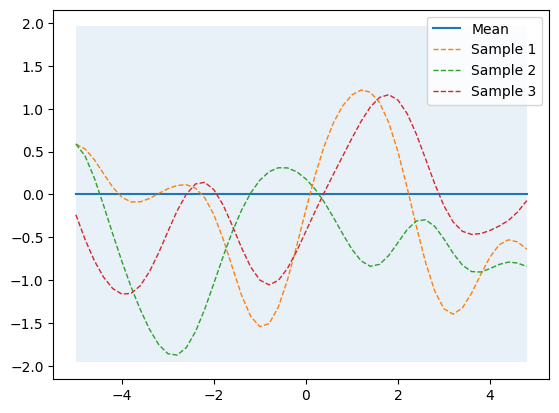

In [3]:
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)
gp.plot_gp(mu, cov, X, samples=samples)

Posterior

In [4]:
X_train = jnp.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
def f(x):
    return jnp.sin(x)

In [5]:
# no noise y
Y_train = vmap(f)(*X_train.T)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = gp.posterior_jit(X, X_train, Y_train)

/tmp/ipykernel_2749/1916472893.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)


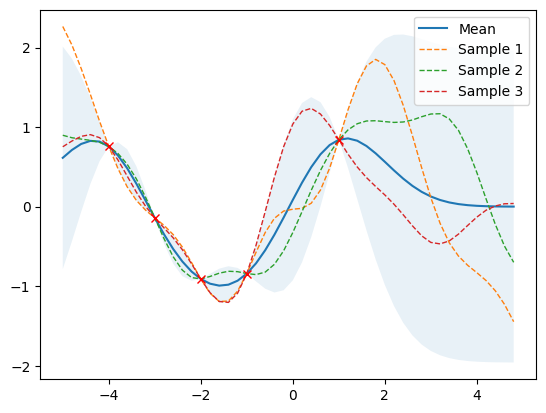

In [6]:
# plot
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
gp.plot_gp(mu_s, cov_s, X, X_train, Y_train, samples=samples)

In [7]:
# noise data
noise = 0.4
noise_values = noise * random.normal(key, shape=X_train.shape)
Y_train = jnp.sin(X_train) + noise_values

In [8]:
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = gp.posterior_jit(X, X_train, Y_train, sigma_y=noise)

/tmp/ipykernel_2749/2217772313.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)


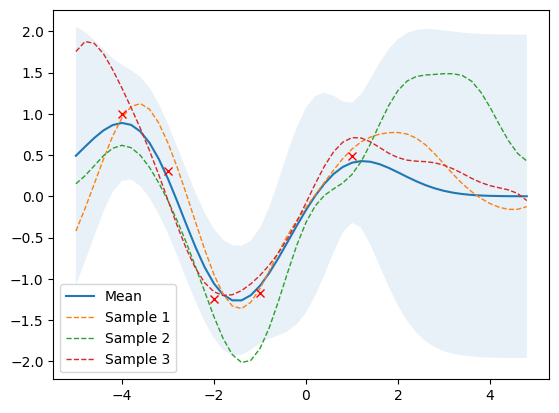

In [9]:
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
gp.plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)